# Section 1

<font color='orange'><b> Slide the 3 x 3 matrix A on the 5 x 5 matrix B and multiply and add up the results. Then store this sum in the result matrix. To solve this question, please navigate over matrix B with basic Python functions and numpy library and calculate the results.

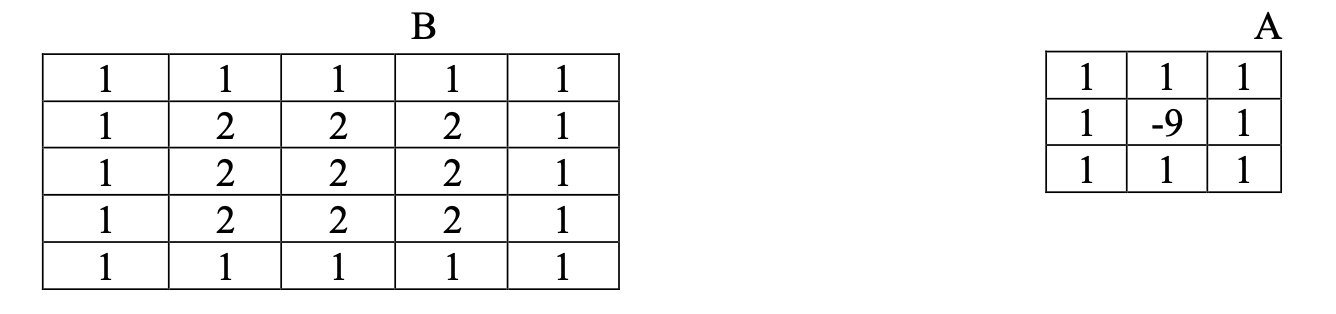


<font color='orange'><b> For a better understanding of the question, pay attention to the following guide

The meaning of sliding matrix A on B is as follows

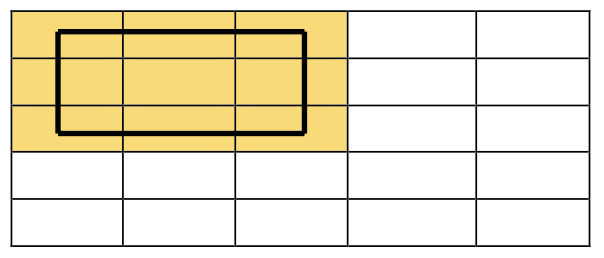

In the specified area, do the multiplication step by step and then add the product of the multiplications and then put it in the resulting matrix:

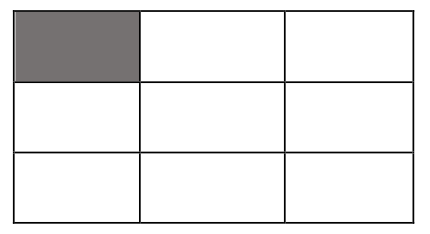

Then move the matrix A to the right by one row and repeat the same operation and place the result in the corresponding row in the output matrix:

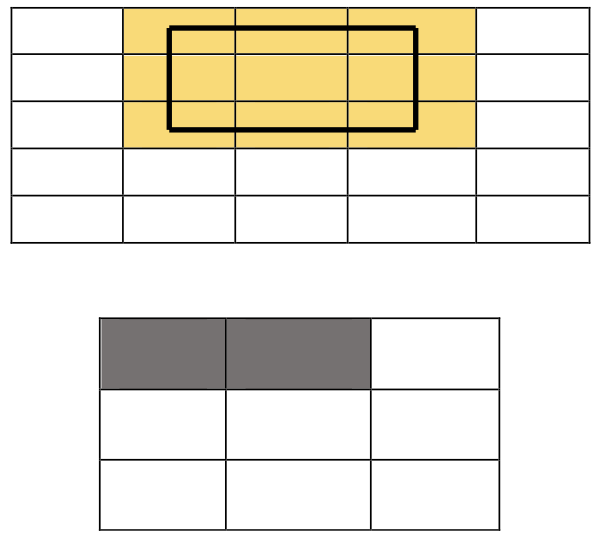


<font color='orange'><b> In the end, please define the filter using *Keras* conv2d layer, set the weights and calculate the results on the same input. Then compare the outputs of your Numpy filter and Keras filter

In [ ]:
'''
Your numpy implementation goes here
'''
import numpy as np


def conv2_compoute(image,kernel):
  h,w = image.shape[:2]
  hk,wk = kernel.shape
  out_h = h - hk +1
  out_w = w - wk +1
  output = np.zeros((out_h,out_w),dtype=np.int32)

  for i in range(out_h):
    for j in range(out_w):
      region = image[i:i+hk,j:j+wk]
      output[i,j] = np.sum(region * kernel)
  return output




In [ ]:
'''
Your Keras implementation goes here
'''


import numpy as np
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Sequential

# 1. Create custom weights
# Kernel weights shape: (filter_height, filter_width, input_channels, num_filters)
# Bias Shape: (num_filters,)

kernel_weights = np.array([
    [[[1]],[[1]],[[1]]],
    [[[1]],[[-9]],[[1]]],
    [[[1]],[[1]],[[1]]]
])
bias_weights = np.array([0])

# 2. Define the Conv2D layer
model = Sequential([
    Conv2D(1,(3,3),input_shape=(5, 5, 1))
])

# Access the Conv2D layer
conv_layer = model.layers[0]

# 3. Set custom weights
conv_layer.set_weights([kernel_weights, bias_weights])

# 4. Create an input image
# Image shape: (batch_size, height, width, channels)
input_image = np.array([[1,1,1,1,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,1,1,1,1]])
print(input_image.shape)
input_image = np.expand_dims(input_image,axis=2)
input_image = np.expand_dims(input_image,axis=0)
# 5. Get the output
output = model.predict(input_image)

np_image = input_image[0,:,:,0]
kernel = np.array([[1,1,1],[1,-9,1],[1,1,1]])
output_numpy = conv2_compoute(np_image,kernel)
# 6. Print the shape and content of the output
print("Output shape:", output.shape)
print("Output values:\n", output)

print("Output of numpy conv2d: \n",output_numpy)


# Section 2

In this task you're goinig to implement and train a ResNet model from scratch on images, crawled from DigiKala website and classifiy them into 10 classes.

Please consider the steps and fill *#TODO* sections

Please use just trainset and valdset of following dataset.

In [ ]:
!gdown 1Mc4skPZe3aehbJ5Zi5TgBNlTxAS797jS

Downloading...
From (original): https://drive.google.com/uc?id=1Mc4skPZe3aehbJ5Zi5TgBNlTxAS797jS
From (redirected): https://drive.google.com/uc?id=1Mc4skPZe3aehbJ5Zi5TgBNlTxAS797jS&confirm=t&uuid=50fd1a22-16d8-4211-aab5-9d0928bb27e8
To: /content/dataset.zip
100% 406M/406M [00:02<00:00, 192MB/s]


In [ ]:
!unzip -qq dataset.zip

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
class BasicBlock(tf.keras.layers.Layer):
    """
    A BasicBlock implements a residual block, a key component of ResNet architectures.

    Purpose:
    - Enables deeper neural networks by using residual connections to mitigate the vanishing gradient problem.
    - Learns a residual mapping instead of the full transformation, making optimization easier and improving performance.
    - Supports downsampling of input spatial dimensions when stride > 1.

    Key Features:
    - Two 3x3 convolutional layers with batch normalization and ReLU activation.
    - A residual shortcut connection that adds the input (identity) to the output of the convolutional block.
    - Optional downsampling for input if spatial or channel dimensions change.

    Input --> [Conv2D (stride)] --> [BatchNorm] --> [ReLU] --> [Conv2D (stride=1)] --> [BatchNorm]  --> ReLU --> OutPut
      \                                                                                            / (Add)
        --------------------------------------------DownSampling----------------------------------
    """
    def __init__(self, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        # First convolutional layer: 3x3 kernel, with stride = stride and no padding and no bias.
        self.conv1 = Conv2D(out_channels,(3,3),padding='same',strides=stride,use_bias=False)
        # Batch normalization
        self.bn1 = BatchNormalization()
        self.relu = ReLU()
        # Second convolutional layer: 3x3 kernel, no downsampling (stride=1) and no padding and no bias.
        self.conv2 = Conv2D(out_channels,(3,3),padding='same',use_bias=False)
        self.bn2 = BatchNormalization()
        self.downsample = downsample

    def call(self, inputs, training=False):
        identity = inputs
        if self.downsample is not None:
            identity = self.downsample(inputs,training=training)

        x = self.conv1(inputs)
        x = self.bn1(x,training=training)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x,training=training)
        x += identity
        x = self.relu(x)
        return x

<>:16: SyntaxWarning: invalid escape sequence '\ '
<>:16: SyntaxWarning: invalid escape sequence '\ '
C:\Users\mahdi\AppData\Local\Temp\ipykernel_18264\3311224038.py:16: SyntaxWarning: invalid escape sequence '\ '
  \                                                                                            / (Add)


In [ ]:
class ResNet(Model):
    """
    ResNet (Residual Network) Implementation.

    Purpose:
    - A deep convolutional neural network architecture that leverages residual connections to train very deep models effectively.
    - Introduced in the seminal ResNet paper (He et al., 2015), it overcomes the vanishing gradient problem by learning residual mappings.

    Key Features:
    - Uses residual blocks (`BasicBlock` or `BottleneckBlock`) to build layers of increasing depth and complexity.
    - Includes downsampling to progressively reduce spatial dimensions while increasing feature map depth.
    - Averages feature maps globally before classification, minimizing the number of parameters in the fully connected layer.

    This implementation supports variable depth based on the `layers` parameter, making it adaptable to ResNet-18, ResNet-34, ResNet-50, and beyond.
    """
    def __init__(self, block, layers, num_classes=10):
        """
        Initialize the ResNet model.

        Parameters:
        - block (Layer class): Type of residual block to use (e.g., `BasicBlock` or `BottleneckBlock`).
        - layers (list of int): Number of blocks in each of the four main layers.
        - num_classes (int): Number of output classes for the classification task.
        """
        super(ResNet, self).__init__()
        # Initial convolutional layer: 7x7 kernel, stride of 2 for downsampling and no padding and no bias.
        self.conv1 = Conv2D(64,(7,7),use_bias=False,strides=(2,2),padding='same')
        # Batch normalization
        self.bn1 = BatchNormalization()
        self.relu = ReLU()
        # Max Pooling with pool size of 3no padding and stride of 2
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=3,strides=2,padding='same')


        # Four main layers of the ResNet, each with multiple residual blocks.
        # Layer configurations are determined by the `layers` parameter.
        # First layer with 64 filters (out_channels).
        # Second layer with downsampling (stride=2).
        # Third layer with 256 filters and downsampling (stride=2).
        # Fourth layer with 512 filters and downsampling (stride=2).

        self.layer1 = self._make_layer(block,out_channels=64,blocks=layers[0],stride=1)
        self.layer2 = self._make_layer(block,out_channels=128,blocks=layers[1],stride=2)
        self.layer3 = self._make_layer(block,out_channels=256,blocks=layers[2],stride=2)
        self.layer4 = self._make_layer(block,out_channels=512,blocks=layers[3],stride=2)

        # Global Average Pooling
        self.avgpool = GlobalAveragePooling2D()
        # Prediction head with softmax activation function
        self.fc = Dense(num_classes,activation='softmax')

    def _make_layer(self, block, out_channels, blocks, stride=1):
        """
        Creates one of the four main layers of ResNet, consisting of multiple residual blocks.

        Parameters:
        - block (Layer class): Residual block type to use (e.g., `BasicBlock`).
        - out_channels (int): Number of output channels for the blocks in this layer.
        - blocks (int): Number of residual blocks in this layer.
        - stride (int): Stride for the first block of the layer (default: 1). Controls downsampling.

        Returns:
        - A Sequential model containing the specified number of residual blocks.
        """
        downsample = None

        # If stride > 1, or input/output channels differ, create a downsampling layer.
        # 1 * 1 Conv2D layer with out_channels and stride and no bias followed by batch normalization.
        if stride != 1:
            downsample = tf.keras.Sequential([
                Conv2D(out_channels,kernel_size=1,strides=stride,use_bias=False),
                BatchNormalization()
            ])

        layers = [block(out_channels, stride, downsample)]

        for _ in range(1, blocks):
            layers.append(block(out_channels))

        return tf.keras.Sequential(layers)

    def call(self, inputs, training=False):
        """
        Forward pass of the ResNet model.

        input -> conv1 -> bn1 -> relu -> maxpool -> layer1 -> layer2 -> layer3 -> layer4 -> avgpool -> fc.

        Parameters:
        - inputs (Tensor): Input tensor (e.g., an image batch).
        - training (bool): Whether the model is in training or inference mode.

        Returns:
        - Tensor: Output logits after passing through the model.
        """
        x = self.conv1(inputs)
        x = self.bn1(x,training=training)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x,training=training)
        x = self.layer2(x,training=training)
        x = self.layer3(x,training=training)
        x = self.layer4(x,training=training)

        x = self.avgpool(x)
        x = self.fc(x)
        return x


In [ ]:
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)

In [ ]:
# Data augmentation and preprocessing using ImageDataGenerator for training and validation datasets.

# Training Data Generator (Apply your own augmentations)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1]
    )
# Validation Data Generator (Apply your own augmentations)
val_datagen = ImageDataGenerator(rescale=1./255,)

# Generate batches of augmented image data for training.
# Set the target size to 224 * 224
# class mode to 'categorical' and your own batch_size
# set the path to the trainset
train_generator = train_datagen.flow_from_directory(
    './data/trainset/',
    target_size = (224,224),
    class_mode='categorical',batch_size=32)
# Generate batches of augmented image data for validating.
# Set the target size to 224 * 224
# class mode to 'categorical' and your own batch_size
# set the path to the validset
val_generator = val_datagen.flow_from_directory(
    './data/validset/',
    target_size = (224,224),
    class_mode='categorical',batch_size=32)
x, y = train_generator[0]


Found 9694 images belonging to 10 classes.
Found 296 images belonging to 10 classes.


In [ ]:
# Compile the model
# set the proper loss and our own optimizer
# monitor the acc
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with your own epochs
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
    )

Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 398s 1s/step - accuracy: 0.1509 - loss: 2.4816 - val_accuracy: 0.1453 - val_loss: 2.4524
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 510s 2s/step - accuracy: 0.1964 - loss: 2.2044 - val_accuracy: 0.1284 - val_loss: 2.6750
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 493s 2s/step - accuracy: 0.2191 - loss: 2.1608 - val_accuracy: 0.1689 - val_loss: 2.3743
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 447s 1s/step - accuracy: 0.2339 - loss: 2.1293 - val_accuracy: 0.1351 - val_loss: 4.7621
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - accuracy: 0.2474 - loss: 2.0846 - val_accuracy: 0.1351 - val_loss: 3.2534
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - accuracy: 0.2578 - loss: 2.0760 - val_accuracy: 0.1182 - val_loss: 2.6162
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.2542 - loss: 2.0806 - val_accuracy: 0.1892 - val_loss: 2.8969
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 465s 2s/step - accuracy: 0.2735 - loss: 2.0351 - val_accu

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot([2])
plt.show()
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Section 3

### Introduction to Transfer Learning

**Transfer learning** is a machine learning technique where a model trained on one task is adapted or fine-tuned to perform a different but related task. Instead of training a model from scratch, transfer learning leverages the knowledge gained from a source domain (pre-training) and applies it to a target domain (fine-tuning). This approach is particularly beneficial when the target domain has limited labeled data, as it reduces training time and improves model performance by building on learned features from the source domain.

In computer vision, transfer learning often involves using pre-trained models on large-scale datasets (like ImageNet) and fine-tuning them for specific tasks such as object detection, image classification, or segmentation.



### Problem Definition: Noisy Bird Classification Using Self-Supervised Learning and Fine-Tuned MobileNetV2

---

#### **Background**
The task of classifying images of birds into predefined categories is a fundamental problem in computer vision with applications in biodiversity monitoring, conservation, and ornithology research. The challenge becomes more complex when working with **noisy datasets**, where:
1. **Unlabeled data** is abundant but lacks annotations.
2. **Labeled data** is limited and may include class imbalances or variability in image quality.

A robust classification model must leverage the unlabeled data effectively while generalizing well to the labeled data for accurate predictions.

---

#### **Objective**
To develop an efficient pipeline for bird image classification by addressing the following key challenges:
1. Utilize **unlabeled data** through self-supervised learning (SSL) to pre-train the model on a rotation-prediction task.
2. Fine-tune the pre-trained model on a **limited labeled dataset** for the final classification task.

The primary aim is to maximize classification accuracy on the labeled dataset by exploiting self-supervised pre-training.

---

#### **Scope**
The problem consists of two distinct but interlinked tasks:
1. **Self-Supervised Learning (SSL):** Train a MobileNetV2 model to predict the rotation angle (0°, 90°, 180°, 270°) applied to unlabeled images, enabling the model to learn generalizable image features.
2. **Fine-Tuning:** Transfer the learned features to a supervised classification task, fine-tuning the model on the labeled dataset for classifying bird species.

This approach ensures that the model extracts meaningful features from the unlabeled dataset, which helps improve performance on the labeled dataset.

---

#### **Challenges**
1. **Unlabeled Data Utilization:** How to effectively use the large volume of unlabeled images for meaningful feature extraction.
2. **Limited Labeled Data:** Mitigating overfitting while fine-tuning on a relatively small labeled dataset.
3. **Feature Representation:** Leveraging the MobileNetV2 architecture, which has proven effective for visual tasks but requires adaptation for SSL.
4. **Evaluation and Visualization:** Measuring the model's performance effectively and ensuring interpretability through visualizations.

---

### Transfer Learning in This Problem

In this problem, transfer learning is implemented in two key stages:

#### 1. **Self-Supervised Pre-Training (Source Task)**
   - **Objective**: Pre-train the MobileNetV2 model on a **self-supervised learning (SSL) task** using unlabeled bird images.
   - **SSL Task**: The model is trained to predict the rotation angle (0°, 90°, 180°, 270°) applied to the input images. This task forces the model to learn general visual features, such as edges, textures, and patterns, which are useful for image understanding.
   - **Importance for Transfer Learning**:
     - Since the dataset is unlabeled, this step leverages self-supervision to extract meaningful features from the data without requiring manual annotations.
     - These learned features serve as a strong initialization point for downstream tasks, reducing the need for extensive labeled data.

---

#### 2. **Fine-Tuning on Labeled Dataset (Target Task)**
   - **Objective**: Fine-tune the pre-trained MobileNetV2 model on a labeled dataset to classify bird images into specific categories.
   - **Transfer Process**:
     - The model’s pre-trained weights from the SSL stage are loaded and adapted to a new classification head designed for the target task (bird species classification).
     - The fine-tuning process adjusts the model parameters to specialize in the labeled dataset while preserving general features learned during pre-training.
   - **Importance**:
     - Fine-tuning builds upon the robust feature representations learned in the SSL stage, leading to faster convergence and improved accuracy on the labeled dataset.
     - This approach effectively addresses the challenge of having limited labeled data by leveraging the unlabeled dataset for pre-training.


---

#### **Results**
1. **Self-Supervised Learning (SSL):**
   - Achieved a steady decrease in rotation prediction loss over epochs, indicating successful feature learning.

2. **Fine-Tuning:**
   - Improved classification accuracy on labeled data due to the transfer of robust feature representations from the SSL stage.
   - Visualized class predictions for randomly selected samples to verify correctness and interpretability.

3. **Visualization and Metrics:**
   - Provided detailed loss and accuracy plots for both SSL and fine-tuning stages.
   - Demonstrated the model's predictions alongside actual labels for qualitative evaluation.


---


### Benefits of Transfer Learning in This Problem
1. **Improved Generalization**: Pre-training helps the model learn domain-specific features (e.g., bird shapes, patterns, and textures) that enhance performance on the target task.
2. **Reduced Overfitting**: Fine-tuning on the labeled dataset starts with strong initial features, reducing the risk of overfitting, especially given the small size of the labeled dataset.
3. **Efficient Training**: By reusing pre-trained weights, training time and computational costs are significantly reduced compared to training from scratch.


In [ ]:
!gdown 1-5t1u5UuqUbiqXcggA-QsMzoS6kpnXMz

Downloading...
From: https://drive.google.com/uc?id=1-5t1u5UuqUbiqXcggA-QsMzoS6kpnXMz
To: /content/Noisy_birds.zip
100% 7.98M/7.98M [00:00<00:00, 17.3MB/s]


In [ ]:
!unzip -qo Noisy_birds.zip -d ./Noisy_birds/

In [ ]:
!mkdir /content/Noisy_birds/labeled

In [ ]:
!mv /content/Noisy_birds/budgie /content/Noisy_birds/labeled
!mv /content/Noisy_birds/canary /content/Noisy_birds/labeled
!mv /content/Noisy_birds/duckling /content/Noisy_birds/labeled
!mv '/content/Noisy_birds/rubber duck' /content/Noisy_birds/labeled

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
data_path = "/content/Noisy_birds"
labeled_path = os.path.join(data_path, "labeled")
unlabeled_path = os.path.join(data_path, "unlabeled")

In [ ]:
# Feel free to adjust the most suitable hyper-parameters


batch_size_ssl = 32
batch_size_ft = 32
epochs_ssl = 10
epochs_ft = 10
learning_rate_ssl = 1e-4
learning_rate_ft = 1e-4
input_shape = (224, 224, 3)

In [ ]:
def rotation_augmentation(image):
    """
    Apply random rotation augmentation to an input image.

    Purpose:
    - Data augmentation technique to artificially increase dataset variability and robustness of the model.
    - Randomly rotates the image by one of four fixed angles (0°, 90°, 180°, or 270°), simulating different orientations
      and helping the model become invariant to rotational changes in the data.

    Parameters:
    - image (Tensor): Input image tensor.

    Returns:
    - rotated_image (Tensor): Rotated image tensor after applying a random rotation.
    - angle_class (int): Corresponding class index (0, 1, 2, or 3) representing the rotation angle.
        - 0: 0° rotation
        - 1: 90° rotation
        - 2: 180° rotation
        - 3: 270° rotation
    """

    # Randomly select one of the four rotation angles: 0°, 90°, 180°, or 270°.
    angle = ...

    # Rotate the input image by the chosen angle.
    # `tf.image.rot90` rotates the image counterclockwise by 90° k times (k = angle // 90).
    rotated_image = tf.image.rot90(image, k=angle // 90)

    # Return the rotated image and the corresponding rotation class (angle // 90).
    return ...

In [ ]:
def load_unlabeled_data(data_dir):
    """
    Load and preprocess unlabeled images from a specified directory.

    Purpose:
    - This function is used to prepare unlabeled image data for semi-supervised learning (SSL).
    - It reads image files from a directory, resizes them to a target input size, and normalizes pixel values.

    Parameters:
    - data_dir (str): Path to the directory containing unlabeled images.

    Returns:
    - images (numpy.ndarray): Array of preprocessed images, where pixel values are normalized to the [0, 1] range.
    """

    # Get full file paths for all image files in the directory.
    file_paths = ...

    # Load and resize images to the target input shape using tf.keras.preprocessing.image.load_img.
    images = ...

    # Convert images to arrays and normalize pixel values to [0, 1].
    images = ...

    return np.array(images)

unlabeled_images = load_unlabeled_data(unlabeled_path)
unlabeled_dataset = tf.data.Dataset.from_tensor_slices(unlabeled_images)
unlabeled_dataset = unlabeled_dataset.map(rotation_augmentation).batch(batch_size_ssl)

In [ ]:
# Build SSL Model with MobileNetV2
# load the imagenet pre-trained weights without top
base_model_ssl = ...

# add global average pooling to the output of the base model
x = ...

x = Dropout(0.2)(x)
# 4 classes for rotation angles
x = Dense(4, activation='softmax')(x)

# Build the model using functional API
ssl_model = ...

In [ ]:
# Compile SSL model with proper variables for loss and optimizer
ssl_model.compile(optimizer = ...,
                  loss = ...,
                  metrics = ['accuracy'])

# Train SSL model
ssl_model.fit(...)

In [ ]:
# Save SSL model
ssl_model.save("ssl_mobilenetv2_model.h5")

In [ ]:
# Fine-tuning with labeled dataset
# Prepare labeled data (split 20% for validation) and use your own augmentations
datagen = ImageDataGenerator(...)

train_gen = datagen.flow_from_directory(
    labeled_path,
    target_size=input_shape[:2],
    batch_size=batch_size_ft,
    subset='training'
)

val_gen = datagen.flow_from_directory(
    labeled_path,
    target_size=input_shape[:2],
    batch_size=batch_size_ft,
    subset='validation'
)

In [ ]:
# Build Fine-Tuning Model
base_model_ft = MobileNetV2(weights=None, include_top=False, input_shape=input_shape)
x = GlobalAveragePooling2D()(base_model_ft.output)
x = Dropout(0.2)(x)
x = Dense(train_gen.num_classes, activation='softmax')(x)
ft_model = Model(base_model_ft.input, x)

In [ ]:
# Load SSL pre-trained weights (without classifier layer)
for layer, ssl_layer in zip(...):
    layer....

In [ ]:
'''
For experiments:

Define the fine-tuning model and initial it with pre-trained weights trained on SSL task.

Conduct Experiments. To improve performance, you can try the following fine-tuning strategies:

1. Full Fine-Tuning: Fine-tune the entire model, including both the backbone and the classification head.
2. Fine-Tune Only the Classification Head: Freeze the backbone layers and fine-tune only the classification head.
3. Define a New Classification Head: Randomly initialize a new classification head while initializing the backbone from pre-trained weights. Train the new head from scratch.
'''


In [ ]:
# Compile FT model with proper variables for loss and optimizer

ft_model.compile(optimizer=...,
                 loss=...,
                 metrics=['accuracy'])

# Train Fine-Tuning Model
history = ft_model.fit(...)

In [ ]:
# Save fine-tuned model
ft_model.save("fine_tuned_mobilenetv2_model.h5")

In [ ]:
# Plot training and validation metrics
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
